In [1]:
import numpy as np
import matplotlib.pyplot as plt

from openpiv import tools, pyprocess, validation, filters, scaling, piv

from PIL import Image

import sys
import pathlib
import multiprocessing
from typing import Any, Union, List, Optional
# import re

import matplotlib.patches as pt
from natsort import natsorted

# from builtins import range
from imageio.v3 import imread, imwrite
from skimage.feature import canny

import glob

import rawpy
import imageio

In [170]:
def load_and_crop(path_1, path_2):
    """ 
    INPUTS:
    path_1, path_2 (str) - Paths to the images that form the image pair
                     ASSUMING 24MP (6000x4000) IMAGES

    OUTPUTS:
    frame_1, frame_2 (ndarray) - Frames of the two images, cropped to only show the sliding interface & blocks
    """

    frame_1 = tools.imread(path_1)
    frame_2 = tools.imread(path_2)

    frame_1 = np.delete(frame_1, np.arange(1900), 0)
    frame_2 = np.delete(frame_2, np.arange(1900), 0)

    frame_1 = np.delete(frame_1, np.arange(280, 2100), 0)
    frame_2 = np.delete(frame_2, np.arange(280, 2100), 0)

    frame_1 = np.delete(frame_1, np.arange(4000, 6000), 1)
    frame_2 = np.delete(frame_2, np.arange(4000, 6000), 1)

    frame_1 = np.delete(frame_1, np.arange(0, 1000), 1)
    frame_2 = np.delete(frame_2, np.arange(0, 1000), 1)

    return frame_1, frame_2

def piv_analysis(frame_1, frame_2, winsize, searchsize, overlap, dt, savetxt):

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_1.astype(np.int32), 
                                                        frame_2.astype(np.int32), 
                                                        window_size=winsize, 
                                                        overlap=overlap, 
                                                        dt=dt, 
                                                        search_area_size=searchsize, 
                                                        sig2noise_method='peak2peak')
    
    x, y = pyprocess.get_coordinates( image_size=frame_1.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

    flags = validation.sig2noise_val( sig2noise, 
                                    threshold = 1.05 )
    # if you need more detailed look, first create a histogram of sig2noise
    # plt.hist(sig2noise.flatten())
    # to see where is a reasonable limit


    # convert x,y to mm
    # convert u,v to mm/sec

    x, y, u3, v3 = scaling.uniform(x, y, u0, v0, 
                                scaling_factor = 10 ) # 96.52 microns/pixel

    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

    tools.save(savetxt, x, y, u3, v3, flags)

    # fig, ax = plt.subplots(figsize=(20,20))
    # tools.display_vector_field(f'{savetxt}.txt', 
    #                         ax=ax, scaling_factor=10, 
    #                         scale=10, # scale defines here the arrow length
    #                         width=0.001, # width is the thickness of the arrow
    #                         on_img=True, # overlay on the image
    #                         image_name='../velocimetry/image.png')
    
def save_vector_field(
    filename: Union[pathlib.Path, str],
    on_img: Optional[bool]=False,
    image_name: Optional[Union[pathlib.Path,str]]=None,
    window_size: Optional[int]=32,
    scaling_factor: Optional[float]=1.,
    ax: Optional[Any]=None,
    width: Optional[float]=0.0025,
    show_invalid: Optional[bool]=True,
    savename: Optional[str]=None,
    **kw):
    

    # print(f' Loading {filename} which exists {filename.exists()}')
    a = np.loadtxt(filename)

    print(a.shape)
    # a = a[a[:, 2] < 0.0001]
    # a = a[a[:, 3] < 0.0001]
    print(a.shape)
    # parse
    x, y, u, v, flags, mask = a[:, 0], a[:, 1], a[:, 2], a[:, 3], a[:, 4], a[:, 5]


    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    if on_img is True:  # plot a background image
        im = imread(image_name)
        xmax = np.amax(x) + window_size / (2 * scaling_factor)
        ymax = np.amax(y) + window_size / (2 * scaling_factor)
        ax.imshow(im, cmap="Greys_r", extent=[0.0, xmax, 0.0, ymax])    


    # first mask whatever has to be masked
    u[mask.astype(bool)] = 0.
    v[mask.astype(bool)] = 0.
    
    # now mark the valid/invalid vectors
    invalid = flags > 0 # mask.astype("bool")  
    valid = ~invalid

    # visual conversion for the data on image
    # to be consistent with the image coordinate system

    # if on_img:
    #     y = y.max() - y
    #     v *= -1

    ax.quiver(
        x[valid],
        y[valid],
        u[valid],
        v[valid],
        color="b",
        width=width,
        **kw
        )
        
    if show_invalid and len(invalid) > 0:
        ax.quiver(
                x[invalid],
                y[invalid],
                u[invalid],
                v[invalid],
                color="r",
                width=width,
                **kw,
                )
    
    
    # if on_img is False:
    #     ax.invert_yaxis()
    
    ax.set_aspect(1.)
    # fig.canvas.set_window_title('Vector field, '+str(np.count_nonzero(invalid))+' wrong vectors')

    fig.savefig(f'../velocimetry/smooth-on-smooth/output/{savename}.png', bbox_inches='tight')

    plt.cla()
    fig.clear()
    

In [63]:
frame_a = tools.imread('../velocimetry/smooth-on-smooth/camera-test-2/IMG_9508.CR2')
frame_b = tools.imread('../velocimetry/smooth-on-smooth/camera-test-2/IMG_9518.CR2')
print(np.shape(frame_a))

frame_a = np.delete(frame_a, np.arange(1800), 0)
frame_b = np.delete(frame_b, np.arange(1800), 0)

frame_a = np.delete(frame_a, np.arange(480, 2200), 0)
frame_b = np.delete(frame_b, np.arange(480, 2200), 0)

frame_a = np.delete(frame_a, np.arange(4700, 6000), 1)
frame_b = np.delete(frame_b, np.arange(4700, 6000), 1)

frame_a = np.delete(frame_a, np.arange(0, 1000), 1)
frame_b = np.delete(frame_b, np.arange(0, 1000), 1)


(4000, 6000)


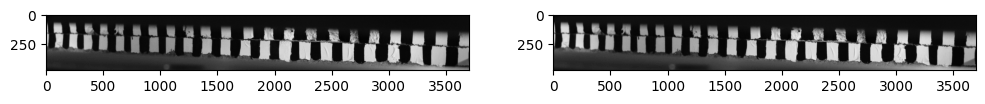

In [64]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

plt.imsave('image.png', frame_a, cmap=plt.cm.gray)

In [57]:
winsize = 20 # pixels, interrogation window size in frame A
searchsize = 21  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 20 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

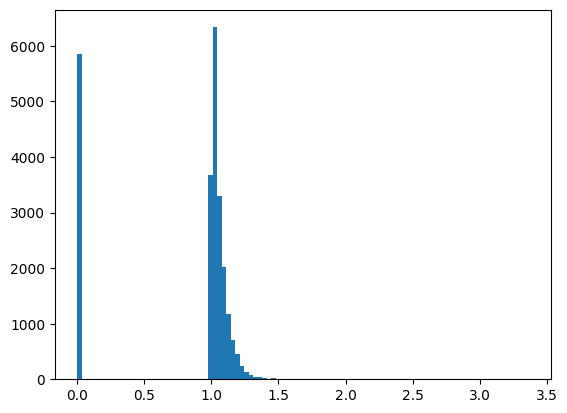

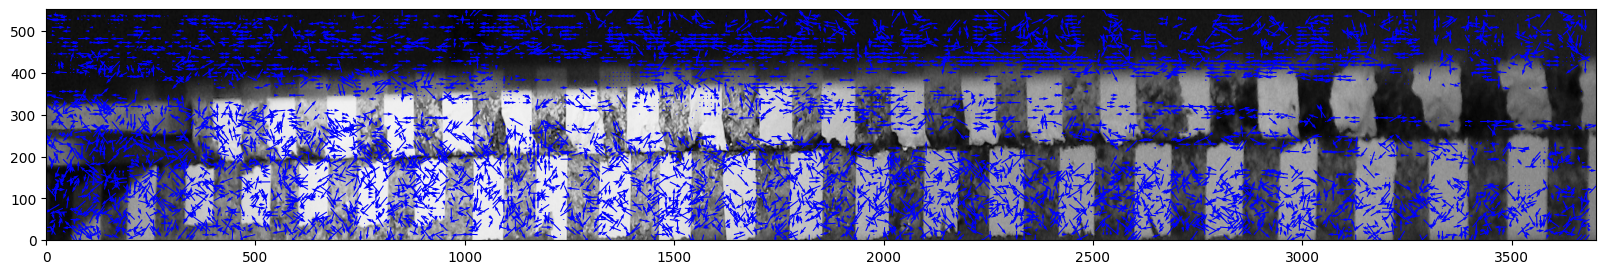

NameError: name 'save_vector_field' is not defined

In [58]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

flags = validation.sig2noise_val( sig2noise, 
                                 threshold = 1.05 )
# if you need more detailed look, first create a histogram of sig2noise
plt.hist(sig2noise.flatten(), bins=100)
# to see where is a reasonable limit


# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u0, v0, 
                               scaling_factor = 1 ) # 96.52 microns/pixel

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

tools.save('exp1_001.txt', x, y, u3, v3, flags)

fig, ax = plt.subplots(figsize=(20,20))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, 
                           scale=50, # scale defines here the arrow length
                           width=0.0007, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           show_invalid=False, # show masked vectors as well
                           image_name='../velocimetry/image.png')

save_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=10, 
                           scale=10, # scale defines here the arrow length
                           width=0.001, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='../velocimetry/image.png')

0
../velocimetry/smooth-on-smooth/final-sequence\IMG_9256.JPG ../velocimetry/smooth-on-smooth/final-sequence\IMG_9257.JPG
(12716, 6)
(12716, 6)
1
../velocimetry/smooth-on-smooth/final-sequence\IMG_9257.JPG ../velocimetry/smooth-on-smooth/final-sequence\IMG_9258.JPG
(12716, 6)
(12716, 6)
2
../velocimetry/smooth-on-smooth/final-sequence\IMG_9258.JPG ../velocimetry/smooth-on-smooth/final-sequence\IMG_9259.JPG
(12716, 6)
(12716, 6)
3
../velocimetry/smooth-on-smooth/final-sequence\IMG_9259.JPG ../velocimetry/smooth-on-smooth/final-sequence\IMG_9260.JPG
(12716, 6)
(12716, 6)
4
../velocimetry/smooth-on-smooth/final-sequence\IMG_9260.JPG ../velocimetry/smooth-on-smooth/final-sequence\IMG_9261.JPG
(12716, 6)
(12716, 6)
5
../velocimetry/smooth-on-smooth/final-sequence\IMG_9261.JPG ../velocimetry/smooth-on-smooth/final-sequence\IMG_9262.JPG
(12716, 6)
(12716, 6)
6
../velocimetry/smooth-on-smooth/final-sequence\IMG_9262.JPG ../velocimetry/smooth-on-smooth/final-sequence\IMG_9263.JPG


KeyboardInterrupt: 

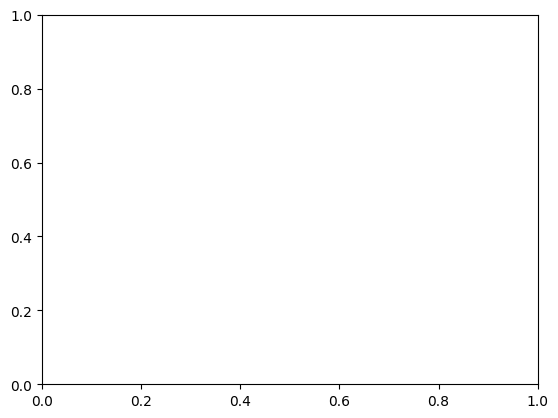

In [171]:
dir_images = '../velocimetry/smooth-on-smooth/final-sequence/'

file_list = glob.glob(dir_images + '/*.JPG')

for i in range(0, 99):

    filename = str(i)
    print(filename)
    
    frame_a, frame_b = load_and_crop(file_list[i], file_list[i+1])
    print(file_list[i], file_list[i+1])

    piv_analysis(frame_a, frame_b, 16, 16, 8, 1, f'../velocimetry/smooth-on-smooth/final-seq-txt/{filename}.txt')

    save_vector_field(f'../velocimetry/smooth-on-smooth/final-seq-txt/{filename}.txt',
                            ax=ax, scaling_factor=10, 
                           scale=100, # scale defines here the arrow length
                           width=0.001, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='../velocimetry/image.png',
                           savename=filename)